In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set()

In this Notebook, we will demonstrate the benefit of using Deep Learning in Portfolio Optimization and compare it to some traditional portfolio optimization technique such as equal weight and Markowitz's Mean Variance Optimization.

We will also demonstrate how Deep Learning strategy improves as we add more variety of data as inputs into the Deep Learning model.

In [61]:
stock_tickers = [ "SPY", "IVV", "VEA", "EFA", "XLF", "XLK", "BND", "AGG", "GLD", "DBC", "IYR", "SCHH", "IJR", "SCHA", "VWO", "EEM", "VYM", "DVY", "VUG", "IWF"]
NUM_ASSETS = len(stock_tickers)
NUM_ASSETS

20

In [3]:
dataset = yf.download(stock_tickers, end="2024-01-01")

[*********************100%%**********************]  20 of 20 completed


In [4]:
dataset = dataset[["Adj Close", "Volume"]]
dataset = dataset.dropna()
return_data = dataset.pct_change().fillna(0)
return_data.replace([np.inf, -np.inf], 0, inplace=True)

In [5]:
L = 60

In [6]:
X_train, X_test = train_test_split(return_data, test_size=0.5, shuffle=False, random_state=7)
X_train.shape, X_test.shape

((1631, 40), (1631, 40))

In [7]:
data_train = []
for i in range(len(X_train.values)-L):
    data_train.append(X_train.values[i:i+L])

data_test = []
for i in range(len(X_test.values)-L):
    data_test.append(X_test.values[i:i+L])

data_train = np.stack(data_train)
data_test = np.stack(data_test)

data_train.shape, data_test.shape

((1571, 60, 40), (1571, 60, 40))

In [8]:
class FinancialDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        batch = self.dataset[idx, :]
        return torch.FloatTensor(batch)

In [9]:
BATCH_SIZE = 32

In [10]:
X_train_iter_1 = DataLoader(dataset=FinancialDataset(dataset=data_train[:, :, :NUM_ASSETS]), batch_size=BATCH_SIZE, shuffle=True)
X_train_iter_2 = DataLoader(dataset=FinancialDataset(dataset=data_train), batch_size=BATCH_SIZE, shuffle=True)

In [11]:
for X1 in X_train_iter_1:
    print(X1.shape)
    break

for X2 in X_train_iter_2:
    print(X2.shape)
    break

torch.Size([32, 60, 20])
torch.Size([32, 60, 40])


In [24]:
class LSTMModel(nn.Module):
    # Temporal Network
    def __init__(self, num_assets, num_features, hidden_size, num_layers=5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.25)
        self.fcl = nn.Linear(in_features=hidden_size*num_layers, out_features=num_assets)
        self.dropout = nn.Dropout(p=0.25)
        self.weight_f = nn.Softmax(dim=1)
        self.num_assets = num_assets

    def forward(self, X):
        _, (feats, _) = self.lstm(X)
        feats = torch.permute(feats, (1,0,2))
        feats = feats.reshape(X.shape[0], -1)
        logits = self.dropout(self.fcl(feats))
        portfolio_weights = self.weight_f(logits - logits.max())
        return portfolio_weights

In [25]:
class SharpeRatioLoss(nn.Module):
    def __init__(self):
        super(SharpeRatioLoss, self).__init__()
        pass

    def forward(self, p_return):
        mu_return = p_return.mean(1)
        volatility = p_return.std(1)
        sharpe_ratio = mu_return/volatility
        sharpe_ratio = sharpe_ratio.mean()
        return -sharpe_ratio

In [26]:
loss_fn = SharpeRatioLoss()
loss_fn

SharpeRatioLoss()

Using Sharpe ratio as an objective function. The goal of the neural network is to learn to maximize the Sharpe Ratio.

In [27]:
class DeepModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.num_assets = self.model.num_assets

    def forward(self, X):
        X = X.unsqueeze(0)
        weights = self.model(X.float())
        weights = weights.squeeze(0)
        return weights

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        weights = self.model(train_batch)
        stock_returns = train_batch[:, :, :self.num_assets]
        p_r = torch.permute(weights*torch.permute(stock_returns, (1,0,2)), (1,0,2))
        p_return = p_r.sum(2)
        loss = loss_fn(p_return)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)
        return loss

    def test_step(self, test_batch, batch_idx):
        weights = self.model(test_batch.float())
        stock_returns = test_batch[:, :, :20]
        p_r = torch.permute(weights*torch.permute(stock_returns, (1,0,2)), (1,0,2))
        p_return = p_r.sum(2)
        loss = loss_fn(p_return)
        self.log("test_loss", loss, on_step=True, on_epoch=False, prog_bar=True, logger=False)
        return loss

In [28]:
MAX_EPOCHS = 30

### 1. LSTM Model: Using only return data as input

In [29]:
lstm_model_1 = DeepModel(
    LSTMModel(num_features=20,
              hidden_size=30,
              num_assets=NUM_ASSETS)
)

In [30]:
trainer_1 = pl.Trainer(max_epochs=MAX_EPOCHS, logger=False, enable_checkpointing=False)
trainer_1.fit(model=lstm_model_1, train_dataloaders=X_train_iter_1)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 39.0 K
------------------------------------
39.0 K    Trainable params
0         Non-trainable params
39.0 K    Total params
0.156     Total estimated model params size (MB)
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 50/50 [00:01<00:00, 49.22it/s, train_loss_step=-0.22, train_loss_epoch=-0.122]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 50/50 [00:01<00:00, 49.18it/s, train_loss_step=-0.22, train_loss_epoch=-0.122]


### 2. LSTM: Using daily return data and daily change in volume as inputs

In [31]:
lstm_model_2 = DeepModel(
    LSTMModel(num_features=40,
              hidden_size=30,
              num_assets=NUM_ASSETS)
)

In [32]:
trainer_2 = pl.Trainer(max_epochs=MAX_EPOCHS, logger=False, enable_checkpointing=False)
trainer_2.fit(model=lstm_model_2, train_dataloaders=X_train_iter_2)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 41.4 K
------------------------------------
41.4 K    Trainable params
0         Non-trainable params
41.4 K    Total params
0.166     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 50/50 [00:01<00:00, 46.85it/s, train_loss_step=-0.0982, train_loss_epoch=-0.149] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 50/50 [00:01<00:00, 46.82it/s, train_loss_step=-0.0982, train_loss_epoch=-0.149]


In [33]:
lstm_model_1.eval(), lstm_model_2.eval()

(DeepModel(
   (model): LSTMModel(
     (lstm): LSTM(20, 30, num_layers=5, batch_first=True, dropout=0.25)
     (fcl): Linear(in_features=150, out_features=20, bias=True)
     (dropout): Dropout(p=0.25, inplace=False)
     (weight_f): Softmax(dim=1)
   )
 ),
 DeepModel(
   (model): LSTMModel(
     (lstm): LSTM(40, 30, num_layers=5, batch_first=True, dropout=0.25)
     (fcl): Linear(in_features=150, out_features=20, bias=True)
     (dropout): Dropout(p=0.25, inplace=False)
     (weight_f): Softmax(dim=1)
   )
 ))

In [34]:
def dl_strat(x, dl_model, L):
    # determining portfolio weights every quarter
    if x.shape[0] < L:
        return
    hist_data = x[-L:].values
    hist_data = torch.tensor(hist_data)
    with torch.no_grad():
        dl_weights = dl_model(hist_data)
    return dl_weights.numpy()

def dl_trade(x, opt_weights):
    # using portfolio weights over next quarter to determine portfolio return
    year_index = x.index.year[0]
    quarter_index = x.index.quarter[0]
    current_weights = opt_weights.loc[year_index, :].loc[quarter_index]
    portfolio_return = (x*current_weights).sum(1)
    return portfolio_return


In [35]:
test_period = return_data.iloc[-X_test.shape[0]:]

In [36]:
lstm_opt_weights_1 = test_period["Adj Close"].groupby([test_period.index.year, test_period.index.quarter]).apply(lambda x: dl_strat(x, lstm_model_1, L))
lstm_opt_weights_1 = lstm_opt_weights_1.shift(1).dropna()

In [37]:
lstm_opt_weights_2 = test_period.groupby([test_period.index.year, test_period.index.quarter]).apply(lambda x: dl_strat(x, lstm_model_2, L))
lstm_opt_weights_2 = lstm_opt_weights_2.shift(1).dropna()

### 3. Equally Weighted Portfolio

In [38]:
eq_weights = 1/len(stock_tickers)
eq_weights

0.05

### 4. Markowitz's Mean Variance Optimization

In [39]:
from scipy.optimize import minimize

In [40]:
def mu_var_opt(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility

def markowitz_optimization(mv_opt_func, mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    initial_weights = np.ones(num_assets) / num_assets

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 0.5) for asset in range(num_assets))
    result = minimize(mv_opt_func, initial_weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x

    return optimal_weights

def mv_opt(x):
    mu_returns = x.mean(0)
    Sigma = x.cov()
    optimal_weights = markowitz_optimization(mu_var_opt, mu_returns, Sigma)
    return optimal_weights

def mv_trade(x, opt_weights):
    year_index = x.index.year[0]
    quarter_index = x.index.quarter[0]
    current_weights = opt_weights.loc[year_index, :].loc[quarter_index]
    portfolio_return = (x*current_weights).sum(1)
    return portfolio_return

In [41]:
mv_optimization_weights = test_period["Adj Close"].groupby([test_period.index.year, test_period.index.quarter]).apply(lambda x: mv_opt(x))
mv_optimization_weights = mv_optimization_weights.shift(1).dropna()

Portfolio Evaluation

In [42]:
test_period = test_period[test_period.index >= "2018"]

In [43]:
eqw_portfolio_return = test_period["Adj Close"].iloc[L:]
eqw_portfolio_return = (eqw_portfolio_return*eq_weights).sum(1)
eqw_portfolio_return.iloc[0] = 0
eqw_portfolio_return = np.cumsum(eqw_portfolio_return)

In [44]:
mv_portfolio_return = test_period["Adj Close"].groupby([test_period.index.year, test_period.index.quarter]).apply(lambda x: mv_trade(x, mv_optimization_weights))
mv_portfolio_return.index = mv_portfolio_return.index.droplevel([0,1])
mv_portfolio_return = mv_portfolio_return[eqw_portfolio_return.index]
mv_portfolio_return = np.cumsum(mv_portfolio_return)

In [45]:
lstm_portfolio_return_1 = test_period["Adj Close"].groupby([test_period.index.year, test_period.index.quarter]).apply(lambda x: dl_trade(x, lstm_opt_weights_1))
lstm_portfolio_return_1.index = lstm_portfolio_return_1.index.droplevel([0,1])
lstm_portfolio_return_1 = np.cumsum(lstm_portfolio_return_1)

In [46]:
lstm_portfolio_return_2 = test_period["Adj Close"].groupby([test_period.index.year, test_period.index.quarter]).apply(lambda x: dl_trade(x, lstm_opt_weights_2))
lstm_portfolio_return_2.index = lstm_portfolio_return_2.index.droplevel([0,1])
lstm_portfolio_return_2 = np.cumsum(lstm_portfolio_return_2)

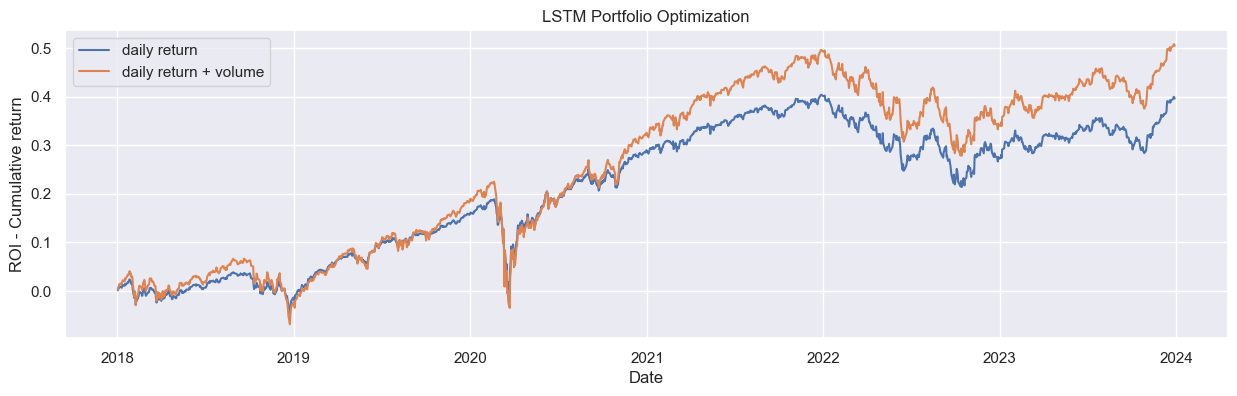

In [60]:
plt.figure(figsize=(15,4))
plt.plot(lstm_portfolio_return_1.index, lstm_portfolio_return_1, label='daily return')
plt.plot(lstm_portfolio_return_2.index, lstm_portfolio_return_2, label='daily return + volume')
plt.xlabel("Date")
plt.ylabel("ROI - Cumulative return")
plt.legend()
plt.title("LSTM Portfolio Optimization")
plt.show()

We can see that with having the additional change in volume fed into the network, the network is able to learn and leverage this information and this led to portfolio weights with better cumulative return with as similar of a risk value. 

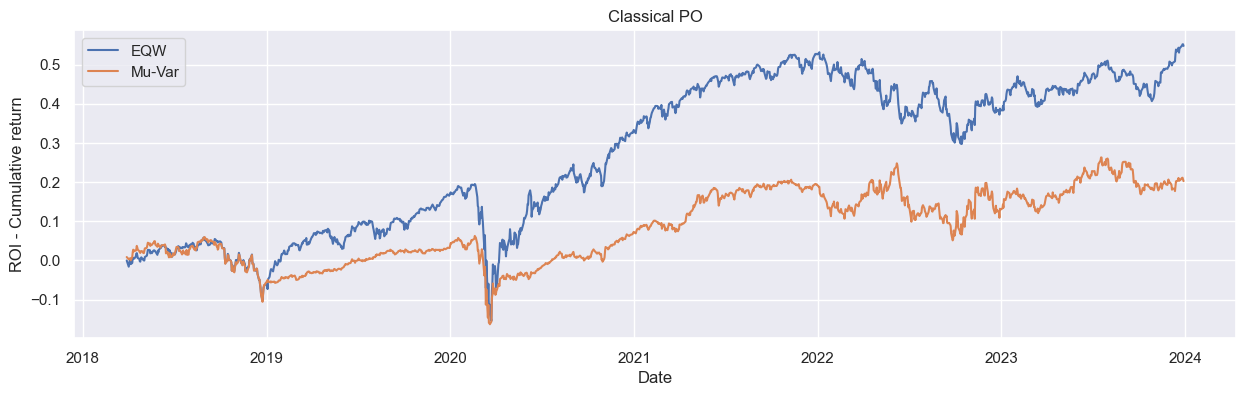

In [59]:
plt.figure(figsize=(15,4))
plt.plot(eqw_portfolio_return.index, eqw_portfolio_return, label='EQW')
plt.plot(mv_portfolio_return.index, mv_portfolio_return, label='Mu-Var')
plt.xlabel("Date")
plt.ylabel("ROI - Cumulative return")
plt.legend()
plt.title("Classical PO")
plt.show()

The classical Portfolio Optimization techniques's capability is only limited to the daily return data, covariance matrix whereas with deep learning we can train networks with many more inputs. Comparing both of them results in the following graph below. 

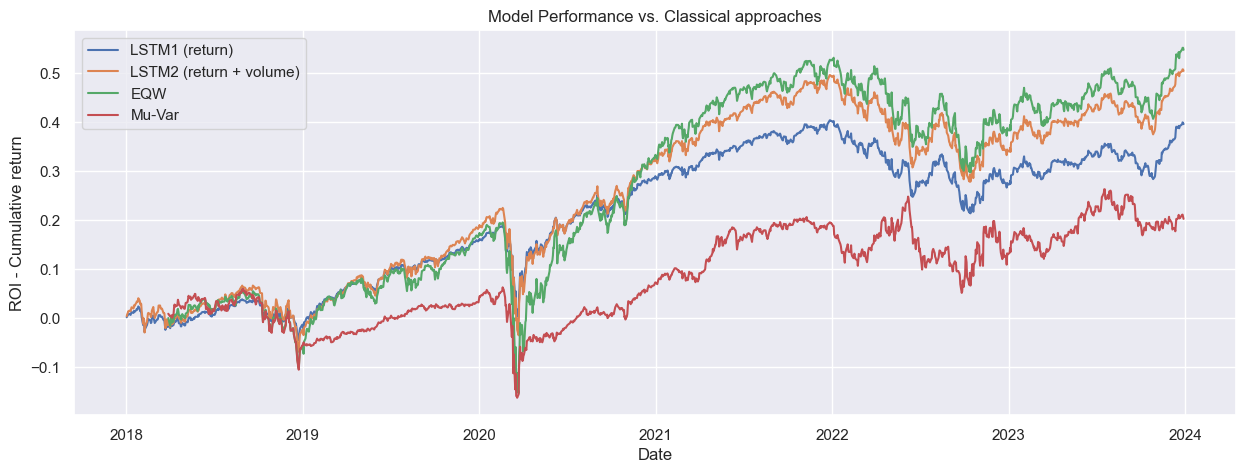

In [58]:
plt.figure(figsize=(15,5))
plt.plot(lstm_portfolio_return_1.index, lstm_portfolio_return_1, label='LSTM1 (return)')
plt.plot(lstm_portfolio_return_2.index, lstm_portfolio_return_2, label='LSTM2 (return + volume)')
plt.plot(eqw_portfolio_return.index, eqw_portfolio_return, label='EQW')
plt.plot(mv_portfolio_return.index, mv_portfolio_return, label='Mu-Var')
plt.xlabel("Date")
plt.ylabel("ROI - Cumulative return")
plt.legend()
plt.title("Model Performance vs. Classical approaches")
plt.show()

Takeaway from this analysis is that: by simply adding the daily change in volume to the same LSTM network, it was able to extract better portfolio weights and have a better cumulative return. The LSTM model performs almost as good as the equally weighted portfolio. 

What is interesting for us is that if we use more variety in data or use different Deep Learning Architectures such as CNNs or Transformers, we can test how well they perform in comparison to one another, thus giving us more insights on Architectural Capability in Portfolio Optimization.